<a href="https://colab.research.google.com/github/bchuchucaa/RNNConsumoDeAgua/blob/main/LstmWaterConsumption1990_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
#import prince
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from keras.layers import RepeatVector
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from math import sqrt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow import keras

In [ ]:
df_cpu_pivot= pd.read_csv('/content/1990-2021.csv')

In [ ]:
df_cpu_pivot.shape

(379, 19)

In [ ]:
df_cpu_pivot.tail()

,Date,United States(USD),Europe(EUR),Japan(JPY),United Kingdom(GBP),Canada(CAD),Switzerland(CHF),India(INR),China(CNY),Turkey(TRY),Saudi Arabia(SAR),Indonesia(IDR),United Arab Emirates(AED),Thailand(THB),Vietnam(VND),Egypt(EGP),South Korean(KRW),Australia(AUD),South Africa(ZAR)
374,2021-03-31,1691.1,1438.8,186861.0,1225.7,2125.4,1591.5,123639.0,11084.8,13995.6,6342.1,24562502.0,6211.5,52845.3,39020979.9,26579.1,1913845.9,2220.3,24970.5
375,2021-04-30,1767.7,1468.4,193213.0,1276.7,2174.6,1612.2,130934.3,11439.4,14657.4,6628.9,25533702.8,6492.8,55040.2,40753168.5,27681.4,1966245.4,2288.4,25644.2
376,2021-05-31,1900.0,1554.0,207845.0,1336.6,2295.3,1708.7,137979.1,12084.8,16105.4,7125.4,27131285.3,6978.3,59344.9,43786246.6,29772.2,2110939.4,2454.6,26067.3
377,2021-06-30,1763.2,1486.8,195692.0,1276.3,2183.3,1629.8,131054.9,11392.5,15317.4,6612.5,25565673.6,6476.3,56509.0,40580658.2,27672.6,1985571.3,2348.5,25175.6
378,2021-07-30,1825.8,1539.7,200376.1,1313.2,2279.2,1654.7,135863.2,11787.6,15376.5,6847.3,26404909.4,6706.3,60007.8,41910091.3,28673.4,2100068.9,2483.8,26708.4


In [ ]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

#df_cpu_pivot.reset_index(inplace=True)

df_cpu_pivot['Date'] = pd.to_datetime(df_cpu_pivot['Date'])

trace1 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot['United Kingdom(GBP)'],
 mode = 'lines',
 name = 'Rosario'
)
trace2 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot['Europe(EUR)'],
 mode = 'lines',
 name = 'Issac'
)
trace3 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot['China(CNY)'],
 mode = 'lines',
 name = 'Jimmy'
)
layout = go.Layout(
 title = 'CONSUMO DE AGUA',
 xaxis = {'title' : 'Date'},
 yaxis = {'title' : 'Consumo'}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [ ]:
from datetime import datetime
train_test_split = datetime.strptime('01.12.2018', '%d.%m.%Y')
df_train = df_cpu_pivot.loc[df_cpu_pivot['Date'] < train_test_split]
df_test = df_cpu_pivot.loc[df_cpu_pivot['Date'] >= train_test_split]
from sklearn.preprocessing import MinMaxScaler
cpu_list = [i for i in df_cpu_pivot.columns if i != 'Date']
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train[cpu_list])
scaled_test = scaler.transform(df_test[cpu_list])

In [ ]:
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)):     
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)   
 return np.array(X), np.array(y)

In [ ]:
# Take into consideration last 6 hours, and perform forecasting for next 1 hour
LOOK_BACK = 3
FORECAST_RANGE = 1
n_features = len(cpu_list)
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(344, 3, 18)
(344, 1, 18)
(29, 3, 18)
(29, 1, 18)


In [ ]:
checkpoint_filepath = 'path_to_checkpoint_filepath'
checkpoint_callback = ModelCheckpoint(
    
 filepath=checkpoint_filepath,
 save_weights_only=False,
 monitor='val_loss',
 mode='min',
 save_best_only=True)

early_stopping_callback = EarlyStopping(
 monitor='val_loss',
 min_delta=0.001,
 patience = 10,
 mode='min'
)

rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.001, mode='min', patience=3, min_lr=0.0001)


In [ ]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse 

In [ ]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    #print('mape:', mape)
    rmse = sqrt(mse)
    #print('RMSE: %f' % rmse)

In [ ]:
def graph_predictions(y_test_inverse,yhat_inverse):
  label=list(range(0,len(y_test_inverse)))
  plt.plot(label, y_test_inverse, label = "Real")
  plt.plot(label, yhat_inverse, label = "Prediccion")
  plt.legend()
  plt.show()

Epoch 1/120
17/17 [==============================] - 4s 36ms/step - loss: 0.1816 - val_loss: 0.5387 - lr: 0.0010
Epoch 2/120
17/17 [==============================] - 0s 9ms/step - loss: 0.1424 - val_loss: 0.3149 - lr: 0.0010
Epoch 3/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0907 - val_loss: 0.1952 - lr: 0.0010
Epoch 4/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0636 - val_loss: 0.1326 - lr: 0.0010
Epoch 5/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0442 - val_loss: 0.0815 - lr: 0.0010
Epoch 6/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0299 - val_loss: 0.0499 - lr: 0.0010
Epoch 7/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0203 - val_loss: 0.0318 - lr: 0.0010
Epoch 8/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0138 - val_loss: 0.0226 - lr: 0.0010
Epoch 9/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0099 - val_loss: 0.0186 - lr

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 296ms/step - loss: 0.0042 - val_loss: 0.0118 - lr: 0.0010
Epoch 14/120
17/17 [==============================] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 6s 351ms/step - loss: 0.0039 - val_loss: 0.0112 - lr: 0.0010
Epoch 15/120
12/17 [====================>.........] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 323ms/step - loss: 0.0034 - val_loss: 0.0098 - lr: 0.0010
Epoch 16/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.0100 - lr: 0.0010
Epoch 17/120
17/17 [==============================] - ETA: 0s - loss: 0.0030INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 6s 357ms/step - loss: 0.0030 - val_loss: 0.0079 - lr: 0.0010
Epoch 18/120
14/17 [=======================>......] - ETA: 0s - loss: 0.0030INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 307ms/step - loss: 0.0028 - val_loss: 0.0062 - lr: 0.0010
Epoch 19/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0028 - val_loss: 0.0064 - lr: 0.0010
Epoch 20/120
16/17 [===========================>..] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 6s 363ms/step - loss: 0.0028 - val_loss: 0.0050 - lr: 0.0010
Epoch 21/120
12/17 [====================>.........] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 305ms/step - loss: 0.0025 - val_loss: 0.0049 - lr: 0.0010
Epoch 22/120
16/17 [===========================>..] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 6s 358ms/step - loss: 0.0025 - val_loss: 0.0035 - lr: 0.0010
Epoch 23/120
15/17 [=========================>....] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 304ms/step - loss: 0.0024 - val_loss: 0.0033 - lr: 0.0010
Epoch 24/120
16/17 [===========================>..] - ETA: 0s - loss: 0.0023INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 6s 349ms/step - loss: 0.0023 - val_loss: 0.0018 - lr: 0.0010
Epoch 25/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0039 - lr: 0.0010
Epoch 26/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0033 - lr: 0.0010
Epoch 27/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0029 - lr: 0.0010
Epoch 28/120
15/17 [=========================>....] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 319ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 1.0000e-04
Epoch 29/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0019 - lr: 1.0000e-04
Epoch 30/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0016 - lr: 1.0000e-04
Epoch 31/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0016 - lr: 1.0000e-04
Epoch 32/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0016 - lr: 1.0000e-04
Epoch 33/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0015 - lr: 1.0000e-04
Epoch 34/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0015 - lr: 1.0000e-04
mae: tf.Tensor(0.17389202, shape=(), dtype=float32)
mse: tf.Tensor(0.059106834, shape=(), dtype=float32)


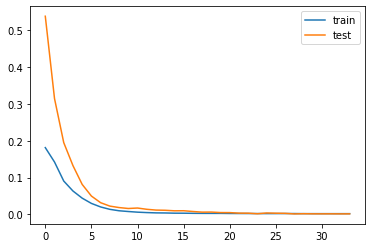

In [ ]:
##no tocar
epochs = 120
batch_size = 21
validation = 0.0001
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(60, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(60, activation='relu', return_sequences=True))
model_enc_dec.add(Dense(12,activation='relu'))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')
plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
#mae: tf.Tensor(0.28951144, shape=(), dtype=float32)
#mse: tf.Tensor(0.5676451, shape=(), dtype=float32)

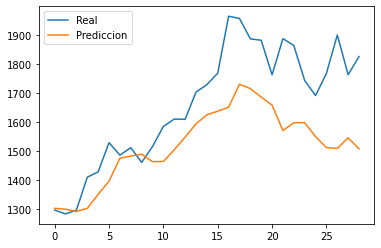

,real,prediccion
0,1295.4,1301.534546
1,1282.3,1298.670166
2,1295.6,1290.938110
3,1409.0,1301.586792
4,1427.6,1349.934692
5,1528.4,1395.064575
6,1485.3,1474.738525
7,1511.0,1482.147461
8,1460.2,1488.477783
9,1514.8,1462.842773


In [ ]:
user=0
graph_predictions(y_test_inverse[:,user],yhat_inverse[:,user])
df_concat=pd.DataFrame({'real': y_test_inverse[:,user] , 'prediccion':yhat_inverse[:,user]})
df_concat

Predicciones nuevas de los Usuarios Segun las 3 ultima fechas saca la prediccion del nuevo mes de consumo

In [ ]:
from numpy import array
x_input = df_cpu_pivot.iloc[376:379,1:].values
x_input.shape
x_input=scaler.transform(x_input)
x_input = x_input.reshape((1, 3, 18))
yhat = model_enc_dec.predict(x_input, verbose=0)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [ ]:
from pandas.tseries.offsets import MonthBegin,MonthEnd
yhat = yhat.reshape(-1, yhat.shape[-1])
yhat=pd.DataFrame(scaler.inverse_transform(yhat))
yhat['Date'] = pd.to_datetime(df_cpu_pivot['Date'].max(), format="%Y%m%d") + MonthBegin(1)+MonthEnd(1)

In [ ]:
plot_data = [
    go.Scatter(
        x=df_cpu_pivot['Date'],
        y=df_cpu_pivot['United States(USD)'],
        name='actual'
    ),
    go.Scatter(
        x=yhat.Date,
        y=yhat.iloc[:,0],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Time Series Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'

Timestamp('1990-02-28 00:00:00')

In [ ]:
df_cpu_pivot.Date.iloc[1].strftime('%Y/%m/%d')

'1990-02-28'

In [ ]:
date_format = '%d/%m/%Y'

dtObj = datetime.strptime(df_cpu_pivot.Date.iloc[1].strftime('%d/%m/%Y'), date_format)
# Add 20 months to a given datetime object
n = 1
future_date = dtObj + relativedelta(months=n)

In [ ]:
future_date

datetime.datetime(1990, 3, 28, 0, 0)